Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from word2vec import Word2Vec
import os
from six.moves.urllib.request import urlretrieve
import zipfile

/home/florian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
w2v = Word2Vec(batch_size=128,
               embedding_size=128, # Dimension of the embedding vector.
               skip_window=1, # How many words to consider left and right.
               num_skips=2, # How many times to reuse an input to generate a label.
               valid_size=16, # Random set of words to evaluate similarity on.
               valid_window=100, # Only pick dev samples in the head of the distribution.
               num_sampled=64, # Number of negative examples to sample.
               vocabulary_size=5000,
               log_folder='./')

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """
  Download a file if not present, and make sure it's the right size.
  """
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

zip_ref = zipfile.ZipFile('text8.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

Found and verified text8.zip


Read the data into a list of strings.

In [4]:
words = Word2Vec.text_file_to_list('text8')
  
print('Data size %d for file %s' % (len(words), filename))

Data size 17005207 for file text8.zip


Build the dictionary and replace rare words with UNK token.

In [5]:
data, count, dictionary, reverse_dictionary = w2v.build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 2735459], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [0, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Method to generate a training batch for the skip-gram model.

This will be used in the neext session.

In [6]:
print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels, data_index = Word2Vec.generate_batch(data=data,
                                                        batch_size=8,
                                                        num_skips=num_skips,
                                                        skip_window=skip_window,
                                                       data_index=data_index)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['UNK', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['UNK', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'a', 'originated', 'UNK', 'of', 'term', 'as', 'originated']


## Train a skip-gram model.

Embedding is basically a technique which consists of reducing the dimensionality of the vocabulary into a smaller space.
The representations of the similars word end up being very close (low distance) between each other in the embedding space.

In [7]:
w2v.initialize()

In [8]:
w2v.run(data, num_steps=100001, reverse_dictionary=reverse_dictionary)

Initialized
Average loss at step 0 / 100001: 6.606665
Nearest to see: thin, matches, less, secure, fought, winds, areas, sovereignty,
Nearest to known: saw, uss, survive, byzantine, fiction, amino, remainder, notes,
Nearest to history: kansas, del, masters, specialized, r, killing, publicly, makes,
Nearest to this: indigenous, divine, failed, mere, victoria, tour, budget, had,
Nearest to during: view, places, poles, capabilities, estate, facility, agriculture, date,
Nearest to the: aim, reach, isbn, baby, currently, brazil, failed, dry,
Nearest to so: honour, bus, attended, underground, minority, east, aid, circular,
Nearest to united: macintosh, purpose, http, congo, coalition, win, angel, folk,
Nearest to into: minority, call, caribbean, explained, mi, characterized, symphony, attended,
Nearest to first: herbert, did, strength, registered, enough, tribes, failed, naval,
Nearest to b: catholicism, chain, studied, fiscal, our, traditional, scope, ethnic,
Nearest to its: particles, amer

Average loss at step 52000 / 100001: 3.180207
Average loss at step 54000 / 100001: 3.195312
Average loss at step 56000 / 100001: 3.210997
Average loss at step 58000 / 100001: 3.196683
Average loss at step 60000 / 100001: 3.198786
Nearest to see: list, links, probability, include, can, interactive, tend, called,
Nearest to known: used, defined, such, possible, regarded, considered, described, called,
Nearest to history: list, geography, economy, main, article, creative, federation, politics,
Nearest to this: which, it, that, there, itself, however, some, what,
Nearest to during: after, in, although, under, at, throughout, provides, maximum,
Nearest to the: their, its, any, a, his, UNK, these, some,
Nearest to so: too, honour, something, legislature, then, gun, angle, vice,
Nearest to united: congo, win, greatest, frequent, omega, constitution, angel, northern,
Nearest to into: from, through, around, out, down, back, mi, within,
Nearest to first: last, second, next, final, same, longest,

In [9]:
num_points=400
tsne_rep = Word2Vec.get_tsne_representation(w2v.final_embeddings,
                                            perplexity=30,
                                            n_components=2,
                                            init='pca',
                                            n_iter=5000,
                                            method='exact',
                                            num_points=num_points)

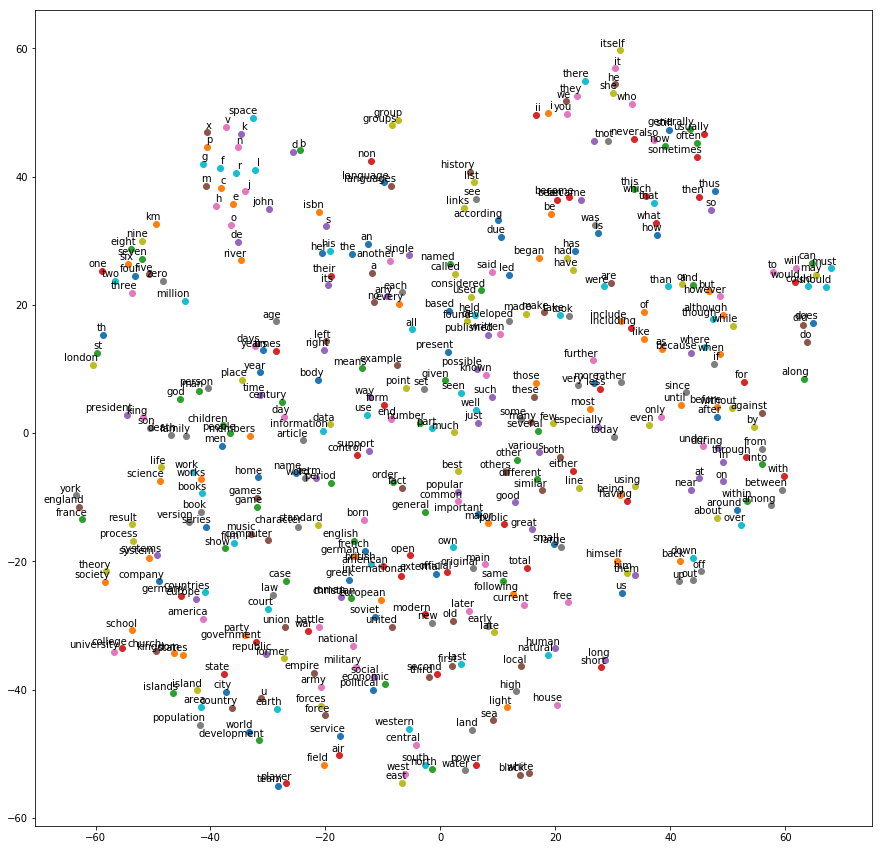

In [10]:
labels = [reverse_dictionary[i] for i in range(1, num_points+1)]
Word2Vec.plot_2d_tsne(tsne_rep, labels)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---